# HW03
Deep Learning, AI5302, 2025, Spring, (Tue/Thurs 2:30~3:45)
***

### Problem1. Build cat and dog detection dataset code
- Use the data from https://drive.google.com/drive/folders/1QUwvm0tgGAOLybIsexrA-aN4U_-DvRKd?usp=drive_link
- You can also download from https://www.kaggle.com/datasets/andrewmvd/dog-and-cat-detection
- Build detection dataset code
- Check your dataset code
----

### Problem2. Train cat and dog detection data using FasterRCNN
- Training detection dataset
- Check the result
- Analysis your result

***
### You can add additional code for checking your image and model.
### You must summit ``.ipynb`` file. Do not summit ``.py`` file.
---

### How to submit your homework
Submit your jupyter notebook file with the filename of  *HW03_studentnumber.ipynb*  on GIST LMS

Ex) HW03_20222015.ipynb  

### Submission deadline
**2025.05.21, Wednesday 23:59 (PM)**

### Plagiarism
We encourage you to discuss this homework with your friends or TA, but you should write your own code.

***
***

In [1]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install kagglehub

  Obtaining dependency information for kagglehub from https://files.pythonhosted.org/packages/49/bf/c2a24567bb6bd80c1fe7cb2ed1a332666476f69c313256aff96094bef93e/kagglehub-0.3.12-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 5.3 MB/s eta 0:00:00


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")

print("Path to dataset files:", path)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


## Problem 1. (total 5 pt.)
**Build cat and dog detection dataset code**

- **1**. Build dataset code
- **2**. Split into train dataset and test dataset.
- **3**. Check your dataset code

### Problem 1-1. (2 pt.)
Build dataset code

In [3]:
import os
from bs4 import BeautifulSoup

# This is a reference code for reading an XML file.
# Utilize this code to read an annotation file to extract bbox information.

def read_ann(directory):
    annotations = os.listdir(directory)

    records = []
    for annot_file in annotations:
        with open(os.path.join(directory,annot_file), 'r') as f:
            file = f.read()

        data = BeautifulSoup(file, "lxml")

        objects = data.find_all('object')
        length = len(objects)
        filename = data.find("filename").text
        # img_width = int(data.find('size').width.text)
        # img_height = int(data.find('size').height.text)

        for i in range(length):
            class_name = data.find_all('object')[i].find('name').text
            xmin = int(data.find_all('object')[i].find('bndbox').find('xmin').text)#/img_width
            ymin = int(data.find_all('object')[i].find('bndbox').find('ymin').text)#/img_height
            xmax = int(data.find_all('object')[i].find('bndbox').find('xmax').text)#/img_width
            ymax = int(data.find_all('object')[i].find('bndbox').find('ymax').text)#/img_height

            records.append([filename,class_name,xmin,ymin,xmax,ymax])
    return records

In [4]:

import os
import numpy as np
import torch
from PIL import Image

class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        self.imgs =  sorted(os.listdir(os.path.join(root, "images"))) # image file name list.
        
        ann_dir = os.path.join(root, "annotations")
        raw_records = read_ann(ann_dir)
        self.ann_dict = {}
        cls_map = {"cat": 1, "dog": 2}  # 필요에 따라 클래스 매핑 수정
        for fname, cls, xmin, ymin, xmax, ymax in raw_records:
            if fname not in self.ann_dict:
                self.ann_dict[fname] = {'boxes': [], 'labels': []}
            self.ann_dict[fname]['boxes'].append([xmin, ymin, xmax, ymax])
            self.ann_dict[fname]['labels'].append(cls_map.get(cls, 0))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, "images", img_name)
        img = Image.open(img_path).convert("RGB")

        ann = self.ann_dict.get(img_name, {'boxes': [], 'labels': []})
        boxes = torch.as_tensor(ann['boxes'], dtype=torch.float32)
        labels = torch.as_tensor(ann['labels'], dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

### Problem 1-2. (2 pt.)
Split into train dataset and test dataset.


In [5]:
batch_size = 64

In [6]:
import sys
sys.path.append('/root/Deep_Learning_HW/vis_utils')

import transforms as T

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))
# used for padding variable-length batches.
# "*" = splat operator : unpacking a list into arguments

In [46]:
import torchvision.transforms as T
import random
import torch
import torchvision.transforms.functional as F

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            image = F.hflip(image)
            w, _ = image.shape[-2:]
            boxes = target["boxes"]
            # x 좌표 반전: [xmin, xmax] → [w - xmax, w - xmin]
            boxes = boxes.clone()
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
            target["boxes"] = boxes
        return image, target
    

class Resize(object):
    def __init__(self, min_size, max_size):
        self.min_size = min_size
        self.max_size = max_size

    def __call__(self, image, target):
        orig_h, orig_w = image.shape[-2:]
        scale = self.min_size / min(orig_h, orig_w)
        new_h = int(round(orig_h * scale))
        new_w = int(round(orig_w * scale))
        if max(new_h, new_w) > self.max_size:
            scale = self.max_size / max(new_h, new_w)
            new_h = int(round(new_h * scale))
            new_w = int(round(new_w * scale))

        image = F.resize(image, [new_h, new_w])
        boxes = target["boxes"].clone()
        boxes[:, [0, 2]] *= (new_w / orig_w)
        boxes[:, [1, 3]] *= (new_h / orig_h)
        target["boxes"] = boxes
        return image, target

def get_transform(train: bool):
    ts = [ToTensor(),
          Resize(min_size=300, max_size=500)]
    if train:
        ts.append(RandomHorizontalFlip(0.5))
    return Compose(ts)

In [20]:
3686 * (8/10)


2948.8

In [47]:
import sys
sys.path.append('/root/Deep_Learning_HW/vis_utils')
import utils
dataset = CatDogDataset('/root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1', get_transform(train=True))
dataset_test = CatDogDataset('/root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:3000])
dataset_test = dataset_test = torch.utils.data.Subset(dataset_test, indices[3000:])

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn = utils.collate_fn) #drop_last=False
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=0, collate_fn= utils.collate_fn)

In [48]:
indices = torch.randperm(len(dataset)).tolist() # Returns a random permutation of integers from 0 to len(dataset)
print(indices)
print(len(indices))

[808, 2285, 2387, 2321, 2134, 558, 2512, 1058, 2393, 160, 2490, 1508, 2934, 339, 466, 1679, 1328, 1666, 1426, 172, 1922, 1968, 59, 1595, 215, 679, 2866, 1596, 971, 519, 1381, 1893, 1231, 1430, 129, 1992, 1591, 1527, 729, 1130, 2467, 1475, 106, 717, 2859, 2761, 1797, 793, 2349, 487, 311, 1681, 2813, 826, 2549, 2432, 1045, 83, 2631, 2561, 2102, 2255, 1222, 1150, 576, 1146, 2246, 15, 2948, 897, 2955, 331, 1195, 1573, 2599, 1109, 2175, 2236, 1274, 102, 1969, 1844, 2739, 893, 594, 1464, 469, 2772, 1864, 642, 1171, 2424, 2756, 2513, 1443, 379, 301, 63, 1315, 2391, 1105, 785, 2262, 30, 1155, 2305, 1538, 1599, 2429, 2592, 1610, 766, 917, 1667, 2174, 871, 2835, 572, 2518, 1054, 2106, 2118, 2298, 366, 1040, 2664, 156, 89, 392, 2714, 1239, 2354, 2914, 2337, 440, 540, 2057, 1061, 493, 111, 2963, 396, 2839, 2566, 560, 1165, 2836, 1260, 93, 728, 2670, 1960, 1587, 1414, 2427, 1065, 658, 904, 223, 1732, 1879, 2845, 1653, 115, 1289, 943, 170, 611, 2888, 1412, 1505, 2517, 521, 334, 632, 1322, 2157, 833,

In [50]:
# Check dataset loader's return
for i, (img, target) in enumerate(data_loader):
  for j in range(batch_size):
    print('SIze of image : (C, H, W) ',img[j].shape)
    print('Number of the objects :', len(target[j]['boxes']))
  if i> 3:
    break

SIze of image : (C, H, W)  torch.Size([3, 300, 449])
Number of the objects : 1
SIze of image : (C, H, W)  torch.Size([3, 303, 300])
Number of the objects : 1
SIze of image : (C, H, W)  torch.Size([3, 300, 400])
Number of the objects : 1
SIze of image : (C, H, W)  torch.Size([3, 450, 300])
Number of the objects : 1
SIze of image : (C, H, W)  torch.Size([3, 300, 400])
Number of the objects : 1
SIze of image : (C, H, W)  torch.Size([3, 300, 400])
Number of the objects : 1
SIze of image : (C, H, W)  torch.Size([3, 300, 375])
Number of the objects : 1
SIze of image : (C, H, W)  torch.Size([3, 400, 300])
Number of the objects : 1
SIze of image : (C, H, W)  torch.Size([3, 300, 400])
Number of the objects : 1
SIze of image : (C, H, W)  torch.Size([3, 300, 400])
Number of the objects : 1
SIze of image : (C, H, W)  torch.Size([3, 300, 400])
Number of the objects : 1
SIze of image : (C, H, W)  torch.Size([3, 300, 450])
Number of the objects : 1
SIze of image : (C, H, W)  torch.Size([3, 400, 300])

### Problem 1-3. (1 pt.)
Check your dataset code

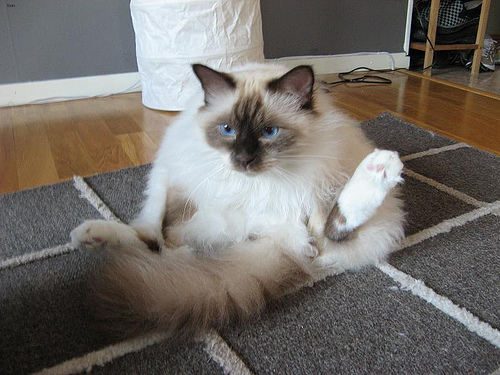

In [51]:
# visualize train image
png_filename = os.path.join('/root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1/images', 'Cats_Test21.png')
png_img = Image.open(png_filename)
# visualize image
png_img

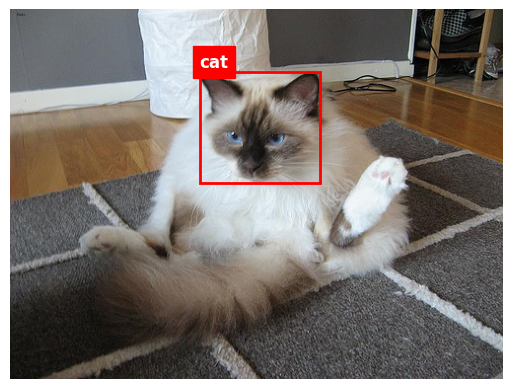

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
xml_path = '/root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1/annotations/Cats_Test21.xml'
tree = ET.parse(xml_path)
root = tree.getroot()
fig, ax = plt.subplots(1)
ax.imshow(png_img)

for obj in root.findall('object'):
    name = obj.findtext('name')
    b = obj.find('bndbox')
    xmin = int(b.findtext('xmin'))
    ymin = int(b.findtext('ymin'))
    xmax = int(b.findtext('xmax'))
    ymax = int(b.findtext('ymax'))
    rect = patches.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(
        xmin,
        ymin - 5,
        name,
        color='white',
        backgroundcolor='r',
        fontsize=12,
        weight='bold'
    )
plt.axis('off')
plt.show()

---
---

## Problem 2. (Total 5 pt.)
- **Train Dogs and Cats data using FasterRCNN**


### Problem 2-1. (3 pt.)
- **Step 1**. Import package.
- **Step 2**. Build your FasterRCNN model.
- **Step 3**. Define hyper-parameter for training
- **Step 4**. Train the model and check the validation results  

In [53]:
''' Step 1 '''
# Import package.
import os
import cv2
import numpy as np
import torch
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [54]:
from engine import *
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset

In [55]:
''' Step 2 '''
# Build your FasterRCNN model.

model  = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) 


# change classififer class size
num_classes = 3 #(cat dog background.)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
''' Step 3 '''
# Define hyper-parameter for training.


batch_size = 4               
num_workers = 4             
val_ratio = 0.2               

num_epochs = 10


optimizer = torch.optim.SGD(model.parameters(), lr=0.005,momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)


In [57]:
''' Step 4 '''
# Train the model and check the validation results
from torch.utils.data import DataLoader, random_split


dataset_total = dataset  #  train dataset indices[:3000] 
n_val = int(len(dataset_total) * val_ratio)
n_train = len(dataset_total) - n_val
train_dataset, val_dataset = random_split(dataset_total, [n_train, n_val])

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, collate_fn=utils.collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False,
    num_workers=num_workers, collate_fn=utils.collate_fn
)



In [58]:
# define model training function

def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    running_loss = 0.0
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    avg_loss = running_loss / len(data_loader)
    print(f"[Epoch {epoch}] Train loss: {avg_loss:.4f}")

def validate(model, data_loader, device):
    model.train()
    running_loss = 0.0
    with torch.no_grad():
        for images, targets in data_loader:
            images  = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            running_loss += losses.item()

    avg_loss = running_loss / len(data_loader)
    print(f"Validation loss: {avg_loss:.4f}")

    model.eval()

In [59]:
batch_size = 32

In [60]:
from tqdm import tqdm

In [61]:
# model training
for epoch in tqdm(range(1, num_epochs + 1), leave= False , desc ="Training Progress: " ):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    validate(model, val_loader, device)
    lr_scheduler.step()


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from N

[Epoch 1] Train loss: 0.1696


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Validation loss: 0.1447


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[Epoch 2] Train loss: 0.1276


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Validation loss: 0.1314


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[Epoch 3] Train loss: 0.1149


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Validation loss: 0.1257


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[Epoch 4] Train loss: 0.1008


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Validation loss: 0.1092


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[Epoch 5] Train loss: 0.0950


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Validation loss: 0.1127


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[Epoch 6] Train loss: 0.0936


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Validation loss: 0.1111


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[Epoch 7] Train loss: 0.0912


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Validation loss: 0.1079


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[Epoch 8] Train loss: 0.0929


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Validation loss: 0.1096


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[Epoch 9] Train loss: 0.0928


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Validation loss: 0.1066


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[Epoch 10] Train loss: 0.0939


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Validation loss: 0.1085


In [62]:
# define model evaluate function
from engine import evaluate



In [63]:
# run evaluate code
evaluate(model, data_loader_test, device=device)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


creating index...
index created!
Test:  [  0/686]  eta: 0:01:13  model_time: 0.0891 (0.0891)  evaluator_time: 0.0023 (0.0023)  time: 0.1069  data: 0.0133  max mem: 7147
Test:  [100/686]  eta: 0:01:00  model_time: 0.0888 (0.0885)  evaluator_time: 0.0022 (0.0022)  time: 0.1120  data: 0.0127  max mem: 7147
Test:  [200/686]  eta: 0:00:49  model_time: 0.0854 (0.0879)  evaluator_time: 0.0022 (0.0023)  time: 0.1039  data: 0.0119  max mem: 7147
Test:  [300/686]  eta: 0:00:39  model_time: 0.0888 (0.0884)  evaluator_time: 0.0025 (0.0024)  time: 0.1053  data: 0.0126  max mem: 7147
Test:  [400/686]  eta: 0:00:29  model_time: 0.0847 (0.0883)  evaluator_time: 0.0021 (0.0024)  time: 0.0993  data: 0.0113  max mem: 7147
Test:  [500/686]  eta: 0:00:19  model_time: 0.0852 (0.0882)  evaluator_time: 0.0021 (0.0023)  time: 0.1000  data: 0.0118  max mem: 7147
Test:  [600/686]  eta: 0:00:08  model_time: 0.0871 (0.0879)  evaluator_time: 0.0025 (0.0024)  time: 0.1053  data: 0.0130  max mem: 7147
Test:  [685/686

### Problem 2-2. (2 pt.)
Analysis your result

In [64]:
from PIL import Image

In [68]:
import cv2
def overlay_instances(img, prediction, threshold=0.8):
    label_dict = {0: 'background', 1: 'cat', 2: 'dog'}  # 모델 클래스에 맞게 수정
    # 1) Tensor → NumPy, 2) RGB→BGR, 3) 메모리 연속화
    ori_img = img.mul(255) \
                 .permute(1,2,0) \
                 .byte() \
                 .cpu() \
                 .numpy()
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_RGB2BGR)
    ori_img = np.ascontiguousarray(ori_img)

    for box, label, score in zip(prediction[0]['boxes'],
                                 prediction[0]['labels'],
                                 prediction[0]['scores']):
        score = score.item()
        if score < threshold:
            continue

        x1, y1, x2, y2 = box.tolist()
        cls = int(label.item())
        color = (255, 0, 0)

        # 바운딩 박스
        cv2.rectangle(ori_img,
                      (int(x1), int(y1)),
                      (int(x2), int(y2)),
                      color, 2)
        # 레이블 배경
        cv2.rectangle(ori_img,
                      (int(x1), int(y1) - 20),
                      (int(x1) + 60, int(y1)),
                      color, -1)
        # 텍스트
        cv2.putText(ori_img,
                    label_dict.get(cls, str(cls)),
                    (int(x1), int(y1) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (255, 255, 255),
                    thickness=1)

    # BGR → RGB로 돌려서 PIL 이미지 생성
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(ori_img)

In [69]:
# Inference on test images
img, _ = dataset_test[3]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
print(prediction)


[{'boxes': tensor([[1.3884e+02, 6.5716e+01, 2.9490e+02, 2.0903e+02],
        [2.6466e+01, 5.9215e+01, 2.0757e+02, 2.1416e+02],
        [1.6277e+01, 7.6299e+01, 1.6576e+02, 1.6966e+02],
        [2.9772e+02, 1.0703e+02, 3.1477e+02, 1.2939e+02],
        [7.0691e+01, 6.0561e+01, 2.0036e+02, 1.6349e+02],
        [1.0154e-01, 5.0364e+01, 8.2351e+01, 1.5495e+02]], device='cuda:0'), 'labels': tensor([2, 2, 2, 2, 2, 2], device='cuda:0'), 'scores': tensor([0.9400, 0.5962, 0.3132, 0.2107, 0.1724, 0.0586], device='cuda:0')}]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


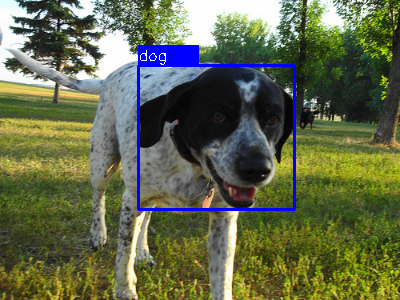

In [70]:
results = overlay_instances(img, prediction, threshold=0.9)
results